# NAIVE BAYES

## I. Chuẩn bị dữ liệu

In [41]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

df = pd.read_csv('../Dataset/archive/WA_Fn-UseC_-HR-Employee-Attrition.csv')

X = df.drop(['Attrition', 'EmployeeNumber', 'Over18', 'EmployeeCount', 'StandardHours'], axis=1)
y = df['Attrition']

col_int32 = ['DailyRate', 'MonthlyIncome', 'MonthlyRate']
col_int16 = ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 
             'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'NumCompaniesWorked', 
             'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 
             'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 
             'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 
             'YearsSinceLastPromotion', 'YearsWithCurrManager']

# ép kiểu
X[col_int32] = X[col_int32].astype('int32')
X[col_int16] = X[col_int16].astype('int16')

X_origin = X.copy()
y_origin = y.copy()

# One-hot cho các cột nominal
one_hot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore',
    drop='first'
)

encode_cols = [
    'BusinessTravel', 'Department', 'EducationField',
    'Gender', 'JobRole', 'MaritalStatus', 'OverTime'
]

X_encoded_array = one_hot_encoder.fit_transform(X_origin[encode_cols])
encoded_columns = one_hot_encoder.get_feature_names_out(encode_cols)

X_encoded_df = pd.DataFrame(
    X_encoded_array, 
    columns=encoded_columns,
    index=X_origin.index
)

# Gộp data sau one-hot
X_encode = pd.concat([X_origin.drop(columns=encode_cols), X_encoded_df], axis=1)

# Encode y
label_encoder = LabelEncoder()
y_encode = label_encoder.fit_transform(y_origin)

# One-hot columns cũng ép về float32
one_hot_cols = X_encoded_df.columns
X_encode[one_hot_cols] = X_encode[one_hot_cols].astype('float32')


In [42]:
print(X_encode.shape)

(1470, 44)


In [43]:
X_encode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1470 non-null   int16  
 1   DailyRate                          1470 non-null   int32  
 2   DistanceFromHome                   1470 non-null   int16  
 3   Education                          1470 non-null   int16  
 4   EnvironmentSatisfaction            1470 non-null   int16  
 5   HourlyRate                         1470 non-null   int16  
 6   JobInvolvement                     1470 non-null   int16  
 7   JobLevel                           1470 non-null   int16  
 8   JobSatisfaction                    1470 non-null   int16  
 9   MonthlyIncome                      1470 non-null   int32  
 10  MonthlyRate                        1470 non-null   int32  
 11  NumCompaniesWorked                 1470 non-null   int16

In [44]:
X_encode

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,49,279,8,1,3,61,2,2,2,5130,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,37,1373,2,2,4,92,2,1,3,2090,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,33,1392,3,4,4,56,3,1,3,2909,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,27,591,2,1,1,40,3,1,2,3468,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,3,41,4,2,4,2571,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1466,39,613,6,1,4,42,2,3,1,9991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1467,27,155,4,3,2,87,4,2,2,6142,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1468,49,1023,2,3,4,63,2,2,2,5390,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [45]:
y_encode

array([1, 0, 1, ..., 0, 0, 0], shape=(1470,))

## II. Định nghĩa Class, Function hỗ trợ

In [46]:
import numpy as np
import pandas as pd

class My_GaussianNB:
    def __init__(self):
        self.classes = None
        self.mean = {}
        self.var = {}
        self.priors = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = X.shape[0]

        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = len(X_c) / n_samples
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0) + 1e-9

    def _gaussian_pdf(self, x, mean, var):
        return np.exp(-((x - mean) ** 2) / (2 * var)) / np.sqrt(2 * np.pi * var)

    def predict_log_proba(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        log_probs = np.zeros((n_samples, n_classes))

        for idx, c in enumerate(self.classes):
            log_prior = np.log(self.priors[c])
            pdf = self._gaussian_pdf(X, self.mean[c], self.var[c])
            log_likelihood = np.sum(np.log(pdf + 1e-9), axis=1)
            log_probs[:, idx] = log_prior + log_likelihood

        return log_probs

    def predict(self, X):
        log_probs = self.predict_log_proba(X)
        return self.classes[np.argmax(log_probs, axis=1)]

class My_BernoulliNB:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.classes = None
        self.feature_prob = {}  # P(feature=1|class)
        self.priors = {}
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples = X.shape[0]
        n_features = X.shape[1]
        
        for c in self.classes:
            X_c = X[y == c]
            n_c = len(X_c)
            
            # Prior probability P(class)
            self.priors[c] = n_c / n_samples
            
            # Feature probability P(feature=1|class) với Laplace smoothing
            # Smoothing: (count + alpha) / (total + 2*alpha)
            # 2*alpha vì Bernoulli có 2 giá trị (0 và 1)
            feature_count = np.sum(X_c, axis=0)
            self.feature_prob[c] = (feature_count + self.alpha) / (n_c + 2 * self.alpha)
        
        return self
    
    def predict_log_proba(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        log_probs = np.zeros((n_samples, n_classes))
        
        for idx, c in enumerate(self.classes):
            log_prior = np.log(self.priors[c])
            
            # Log likelihood cho Bernoulli:
            # log P(X|c) = Σ[x_i * log(p_i) + (1-x_i) * log(1-p_i)]
            p = self.feature_prob[c]
            log_p = np.log(p)
            log_1_p = np.log(1 - p)
            
            # Vectorized calculation
            log_likelihood = X @ log_p + (1 - X) @ log_1_p
            log_probs[:, idx] = log_prior + log_likelihood
        
        return log_probs
    
    # không cộng thêm xác suất tiên nghiệm (log_prior)
    def predict_log_proba_2(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        log_probs = np.zeros((n_samples, n_classes))
        
        for idx, c in enumerate(self.classes):
            log_prior = np.log(self.priors[c])
            
            # Log likelihood cho Bernoulli:
            # log P(X|c) = Σ[x_i * log(p_i) + (1-x_i) * log(1-p_i)]
            p = self.feature_prob[c]
            log_p = np.log(p)
            log_1_p = np.log(1 - p)
            
            # Vectorized calculation
            log_likelihood = X @ log_p + (1 - X) @ log_1_p
            log_probs[:, idx] = log_likelihood
        
        return log_probs
    
    def predict(self, X):
        log_probs = self.predict_log_proba(X)
        return self.classes[np.argmax(log_probs, axis=1)]


In [47]:
# Function dùng để train mô hình kết hợp: Gaussian và Bernoulli

from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def fit_and_evaluate_hybrid(gnb, bnb, 
                           X_train, X_test, 
                           y_train, y_test, 
                           sca = True,
                           use_smote=False,
                           description="Hybrid Gaussian–Bernoulli"):
    print("="*60)
    print(f"ĐANG HUẤN LUYỆN: {description}")


    try:
        X_train = X_train.copy()
        X_test  = X_test.copy()

        continuous_data = [
        'Age', 'DailyRate', 'DistanceFromHome', 
        'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'TotalWorkingYears',
        'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager',

        # Đây là các dữ liệu phân loại có thứ tự ta sẽ chuẩn hóa cùng dữ liệu liên tục và đưa vô gnb
        'Education',
        'EnvironmentSatisfaction',
        'JobInvolvement',
        'JobLevel',
        'JobSatisfaction',
        'PerformanceRating',
        'RelationshipSatisfaction',
        'StockOptionLevel',
        'WorkLifeBalance'
        ]
        
        X_train_num = X_train[continuous_data].to_numpy()
        X_train_cat = X_train.drop(continuous_data, axis=1).to_numpy()

        X_test_num = X_test[continuous_data].to_numpy()
        X_test_cat = X_test.drop(continuous_data, axis=1).to_numpy()

        if sca:
            scaler = StandardScaler()
            X_train_num = scaler.fit_transform(X_train_num)
            X_test_num = scaler.transform(X_test_num)  

        # Apply SMOTE nếu được bật
        if use_smote:
            cat_indices = [i for i in range(X_train_num.shape[1], X_train_num.shape[1] + X_train_cat.shape[1])]
            smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42)
            
            X_combined = np.hstack([X_train_num, X_train_cat])
            X_res, y_res = smote_nc.fit_resample(X_combined, y_train)
            
            # Tách lại thành num + cat
            X_train_num = X_res[:, :X_train_num.shape[1]]
            X_train_cat = X_res[:, X_train_num.shape[1]:]
            y_train = y_res    

        # Fit mô hình
        gnb.fit(X_train_num, y_train)
        bnb.fit(X_train_cat, y_train)

        # Dự đoán cho tập train
        # Predict log xác suất của từng model
        # Lưu ý: Dùng predict_log_proba cho BNB mặc dù bị tính 2 lần xác suất tiên nghiệm nhưng lại cho kết quả tốt hơn 
        log_proba_gnb_train = gnb.predict_log_proba(X_train_num)
        log_proba_bnb_train = bnb.predict_log_proba(X_train_cat)

        # Cộng log xác suất (hybrid)
        combined_log_train = log_proba_gnb_train + log_proba_bnb_train

        # Lấy class dự đoán
        y_pred_train = gnb.classes[np.argmax(combined_log_train, axis=1)]

        # Dự đoán cho tập test
        # Predict log xác suất của từng model
        log_proba_gnb_test = gnb.predict_log_proba(X_test_num)
        log_proba_bnb_test = bnb.predict_log_proba(X_test_cat)

        # Cộng log xác suất (hybrid)
        combined_log_test = log_proba_gnb_test + log_proba_bnb_test

        # Lấy class dự đoán
        y_pred_test = gnb.classes[np.argmax(combined_log_test, axis=1)]

        # Đánh giá
        print(f"\n Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
        print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
        print("\n Classification Report:\n", classification_report(y_test, y_pred_test, zero_division=0))
        print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

    except Exception as e:
        print(f"\n LỖI: {e}")

    print("="*60 + "\n")


In [48]:
# Function dùng để train mô hình chỉ dùng Gausssian

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
def fit_and_evaluate_gaussian_only(gnb, X_train, X_test, y_train, y_test, sca=True, reduce_name=None, description="Only Gaussian"):
    print("="*60)
    print(f"ĐANG HUẤN LUYỆN: {description}")

    try:

        if sca:
            continuous_data = [
            'Age', 'DailyRate', 'DistanceFromHome', 'EmployeeCount',
            'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
            'PercentSalaryHike', 'StandardHours', 'TotalWorkingYears',
            'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
            'YearsSinceLastPromotion', 'YearsWithCurrManager'
            ]
        cont_cols = [col for col in continuous_data if col in X_train.columns]

        scaler = StandardScaler()
        X_train[cont_cols] = scaler.fit_transform(X_train[cont_cols])
        X_test[cont_cols] = scaler.transform(X_test[cont_cols])

        if reduce_name == 'PCA':
            model_rd = PCA(n_components=6)
            X_train = model_rd.fit_transform(X_train)
            X_test = model_rd.transform(X_test)
        elif reduce_name == 'LDA':
            model_rd = LDA(n_components=1)
            X_train = model_rd.fit_transform(X_train, y_train)
            X_test = model_rd.transform(X_test)    

        gnb.fit(X_train, y_train)

        # Dự đoán
        y_pred_train = gnb.predict(X_train)
        y_pred_test = gnb.predict(X_test)

        # Đánh giá kết quả
        print(f"\n Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
        print(f" Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
        print("\n Classification Report (Test):\n", classification_report(y_test, y_pred_test, zero_division=0))
        print("\n Confusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_test))

    except Exception as e:
        print(f"\n LỖI: {e}")
        import traceback
        traceback.print_exc()

    print("="*60 + "\n")


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler

def visualize_hybrid_results(gnb_model, bnb_model, 
                             X_train, X_test, y_train, y_test, 
                             title="Hybrid Model"):
    
    X_train = X_train.copy()
    X_test  = X_test.copy()

    continuous_data = [
        'Age', 'DailyRate', 'DistanceFromHome', 
        'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike', 'TotalWorkingYears',
        'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
        'YearsSinceLastPromotion', 'YearsWithCurrManager',

        # Đây là các dữ liệu phân loại có thứ tự ta sẽ chuẩn hóa cùng dữ liệu liên tục và đưa vô gnb
        'Education',
        'EnvironmentSatisfaction',
        'JobInvolvement',
        'JobLevel',
        'JobSatisfaction',
        'PerformanceRating',
        'RelationshipSatisfaction',
        'StockOptionLevel',
        'WorkLifeBalance'
        
    ]
        
    X_train_num = X_train[continuous_data].to_numpy()
    X_train_cat = X_train.drop(continuous_data, axis=1).to_numpy()

    X_test_num = X_test[continuous_data].to_numpy()
    X_test_cat = X_test.drop(continuous_data, axis=1).to_numpy()
    
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(X_train_num)
    X_test_num = scaler.transform(X_test_num)  

    gnb_model.fit(X_train_num, y_train)
    bnb_model.fit(X_train_cat, y_train)

    # Tính Log Proba
    # Lưu ý: Dùng predict_log_proba cho BNB mặc dù bị tính 2 lần xác suất tiên nghiệm nhưng lại cho kết quả tốt hơn 
    # Dự đoán Class
    log_proba_gnb_test = gnb_model.predict_log_proba(X_test_num)
    log_proba_bnb_test = bnb_model.predict_log_proba(X_test_cat)
    combined_log_test = log_proba_gnb_test + log_proba_bnb_test
    y_pred_test = gnb_model.classes[np.argmax(combined_log_test, axis=1)]
    
    probs = np.exp(combined_log_test)
    probs_sum = np.sum(probs, axis=1, keepdims=True)
    probs = probs / probs_sum 
    y_scores = probs[:, 1] 

    # --- TRỰC QUAN HÓA ---
    plt.figure(figsize=(20, 6))

    # Biểu đồ 1: Heatmap Confusion Matrix
    
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=gnb_model.classes, yticklabels=gnb_model.classes)
    plt.title(f'1. Heatmap Confusion Matrix\n({title})')
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')

    # Biểu đồ 2: So sánh phân phối thực tế vs dự đoán
    
    plt.subplot(1, 3, 2)
    comparison_df = pd.DataFrame({
        'Loại': np.concatenate([['Thực tế'] * len(y_test), ['Dự đoán'] * len(y_pred_test)]),
        'Giá trị': np.concatenate([y_test, y_pred_test])
    })
    sns.countplot(x='Giá trị', hue='Loại', data=comparison_df, palette='muted')
    plt.title('2. Phân phối Thực tế vs Dự đoán')
    plt.xlabel('Lớp (0: Ở lại, 1: Nghỉ việc)')
    plt.ylabel('Số lượng mẫu')

    # Biểu đồ 3: Đường cong Precision-Recall
    
    plt.subplot(1, 3, 3)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR AUC = {pr_auc:.2f}')
    plt.fill_between(recall, precision, alpha=0.2, color='darkorange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('3. Precision-Recall Curve')
    plt.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

## III. Dự đoán với mô hình

In [50]:
from sklearn.model_selection import train_test_split
X_copy_encode, y_copy_encode = X_encode.copy(), y_encode.copy()

### Thực hiện với dữ liệu đã mã hóa onehot và chuẩn hóa

#### 1. Thử nghiệm với mô hình kết hợp (GaussianNB và BernoulliNB)

In [51]:
my_gnb = My_GaussianNB()
my_bnb = My_BernoulliNB()

In [52]:
fit_and_evaluate_hybrid(my_gnb, my_bnb, 
                        *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
                        sca=True,
                        description="Naive gnb+bnb (train/test: 4/1)")

ĐANG HUẤN LUYỆN: Naive gnb+bnb (train/test: 4/1)

 Train Accuracy: 0.8673
Test Accuracy: 0.8912

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94       255
           1       0.63      0.44      0.52        39

    accuracy                           0.89       294
   macro avg       0.77      0.70      0.73       294
weighted avg       0.88      0.89      0.88       294


 Confusion Matrix:
 [[245  10]
 [ 22  17]]



In [53]:
fit_and_evaluate_hybrid(my_gnb, my_bnb, 
                        *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
                        sca=True,
                        description="Naive gnb+bnb (train/test: 7/3)")

ĐANG HUẤN LUYỆN: Naive gnb+bnb (train/test: 7/3)

 Train Accuracy: 0.8601
Test Accuracy: 0.8526

 Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       380
           1       0.46      0.43      0.44        61

    accuracy                           0.85       441
   macro avg       0.69      0.67      0.68       441
weighted avg       0.85      0.85      0.85       441


 Confusion Matrix:
 [[350  30]
 [ 35  26]]



In [54]:
fit_and_evaluate_hybrid(my_gnb, my_bnb, 
                        *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
                        sca=True,
                        description="Naive gnb+bnb (train/test: 6/4)")

ĐANG HUẤN LUYỆN: Naive gnb+bnb (train/test: 6/4)

 Train Accuracy: 0.8662
Test Accuracy: 0.8605

 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       507
           1       0.49      0.36      0.41        81

    accuracy                           0.86       588
   macro avg       0.70      0.65      0.67       588
weighted avg       0.85      0.86      0.85       588


 Confusion Matrix:
 [[477  30]
 [ 52  29]]



#### 2. Thử nghiệm với chỉ mô hình GaussianNB

In [55]:
my_gnb_2 = My_GaussianNB()

In [56]:
fit_and_evaluate_gaussian_only(my_gnb_2,
                               *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
                               description="Only Gaussian (train/test: 4/1)")

ĐANG HUẤN LUYỆN: Only Gaussian (train/test: 4/1)

 Train Accuracy: 0.6794
 Test Accuracy: 0.6905

 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.93      0.69      0.80       255
           1       0.25      0.67      0.36        39

    accuracy                           0.69       294
   macro avg       0.59      0.68      0.58       294
weighted avg       0.84      0.69      0.74       294


 Confusion Matrix (Test):
 [[177  78]
 [ 13  26]]



In [57]:
fit_and_evaluate_gaussian_only(my_gnb_2,
                               *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
                               description="Only Gaussian (train/test: 7/3)")

ĐANG HUẤN LUYỆN: Only Gaussian (train/test: 7/3)

 Train Accuracy: 0.6735
 Test Accuracy: 0.6576

 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.93      0.65      0.77       380
           1       0.24      0.69      0.36        61

    accuracy                           0.66       441
   macro avg       0.59      0.67      0.56       441
weighted avg       0.83      0.66      0.71       441


 Confusion Matrix (Test):
 [[248 132]
 [ 19  42]]



In [58]:
fit_and_evaluate_gaussian_only(my_gnb_2,
                               *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
                               description="Only Gaussian (train/test: 6/4)")

ĐANG HUẤN LUYỆN: Only Gaussian (train/test: 6/4)

 Train Accuracy: 0.6893
 Test Accuracy: 0.6684

 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.93      0.66      0.78       507
           1       0.25      0.69      0.36        81

    accuracy                           0.67       588
   macro avg       0.59      0.68      0.57       588
weighted avg       0.84      0.67      0.72       588


 Confusion Matrix (Test):
 [[337 170]
 [ 25  56]]



#### 3. Nhận xét
- Mô hình Hybrid (GNB + BNB):
    - Độ chính xác (Accuracy): Đạt mức khá cao, dao động từ 85% đến 89% cho tập test(không có dấu hiệu bị overfit).
    - Nhận diện lớp thiểu số (Class 1 - Nghỉ việc):
        - Recall lớp 1: Đạt khoảng 44% (ở tỉ lệ 4/1). Nghĩa là mô hình phát hiện được gần một nửa số nhân viên thực sự nghỉ việc.
        - Precision lớp 1: Đạt 63%, cho thấy khi mô hình dự báo một người nghỉ việc thì khả năng đúng khá cao.
        - F1-score lớp 1: Khoảng 0.52, đây là một kết quả chấp nhận được đối với thuật toán Naive Bayes trên bộ dữ liệu mất cân bằng.

- Mô hình chỉ sử dụng Gaussian:
    - Độ chính xác (Accuracy) sụt giảm nghiêm trọng: Chỉ còn khoảng 65% - 69%.
    - Mặc dù Recall lớp 1 tăng cao (67% - 69%), giúp bắt được nhiều người nghỉ việc hơn, nhưng Precision lớp 1 lại rất thấp (24% - 25%).
    - Từ Confusion Matrix cho thấy có tới 78-132 trường hợp dự báo nhầm người ở lại thành người nghỉ việc (một kết quả tệ).

- Kết luận chung: Phần thực hiện này cho thấy mô hình Hybrid (GNB + BNB) là lựa chọn tối ưu nhất khi làm việc với bộ dữ liệu đã mã hóa và chuẩn hóa, vượt trội hoàn toàn so với việc chỉ dùng Gaussian đơn thuần.

- Nguyên nhân: Với dữ liệu hỗn hợp gồm cả liên tục và phân loại, việc kết hợp Gaussian Naive Bayes và Bernoulli Naive Bayes cho phép mỗi loại đặc trưng được mô hình hóa theo phân phối phù hợp, từ đó cải thiện độ chính xác và nhận diện lớp thiểu số so với chỉ sử dụng Gaussian Naive Bayes.


### Thực hiện với dữ liệu đã được cân bằng (SMOTE)

In [59]:
my_gnb_sm = My_GaussianNB()
my_bnb_sm = My_BernoulliNB()

In [60]:
fit_and_evaluate_hybrid(my_gnb, my_bnb, 
                        *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
                        sca=True,
                        use_smote=True,
                        description="Naive gnb+bnb (train/test: 4/1)")

ĐANG HUẤN LUYỆN: Naive gnb+bnb (train/test: 4/1)

 Train Accuracy: 0.7408
Test Accuracy: 0.6871

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.79       255
           1       0.24      0.62      0.34        39

    accuracy                           0.69       294
   macro avg       0.58      0.66      0.57       294
weighted avg       0.83      0.69      0.73       294


 Confusion Matrix:
 [[178  77]
 [ 15  24]]



In [61]:
fit_and_evaluate_hybrid(my_gnb, my_bnb, 
                        *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
                        sca=True,
                        use_smote=True,
                        description="Naive gnb+bnb (train/test: 7/3)")

ĐANG HUẤN LUYỆN: Naive gnb+bnb (train/test: 7/3)

 Train Accuracy: 0.7251
Test Accuracy: 0.6508

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.66      0.76       380
           1       0.22      0.62      0.33        61

    accuracy                           0.65       441
   macro avg       0.57      0.64      0.55       441
weighted avg       0.82      0.65      0.70       441


 Confusion Matrix:
 [[249 131]
 [ 23  38]]



In [62]:
fit_and_evaluate_hybrid(my_gnb, my_bnb, 
                        *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
                        sca=True,
                        use_smote=True,
                        description="Naive gnb+bnb (train/test: 6/4)")

ĐANG HUẤN LUYỆN: Naive gnb+bnb (train/test: 6/4)

 Train Accuracy: 0.7652
Test Accuracy: 0.6973

 Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      0.80       507
           1       0.26      0.63      0.36        81

    accuracy                           0.70       588
   macro avg       0.59      0.67      0.58       588
weighted avg       0.83      0.70      0.74       588


 Confusion Matrix:
 [[359 148]
 [ 30  51]]



Nhận xét: 
- Sau khi áp dụng kỹ thuật SMOTE để cân bằng dữ liệu, kết quả cho thấy recall của lớp thiểu số chỉ tăng lên một mức nhỏ, trong khi precision, F1-score và accuracy đều giảm so với mô hình huấn luyện trên dữ liệu gốc. Điều này cho thấy mặc dù mô hình đã nhận diện được nhiều mẫu lớp thiểu số hơn, nhưng đồng thời cũng tăng số lượng dự đoán sai, đặc biệt là các dự đoán dương tính giả.
- Tổng kết, trong bài toán này, SMOTE chỉ mang lại lợi ích hạn chế (tăng nhẹ recall) và cần được cân nhắc kỹ trước khi áp dụng.

### Thực hiện với dữ liệu đã giảm chiều

Đối với phần thực hiện với dữ liệu đã giảm chiều(PCA, LDA), sau khi giảm chiều dữ liệu ta sử dụng mô hình chỉ dùng Gaussian

In [63]:
my_gnb_reduce = My_GaussianNB()

#### 1. Giảm chiều sử dụng PCA

In [64]:
fit_and_evaluate_gaussian_only(my_gnb_reduce,
                               *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
                               reduce_name='PCA',
                               description="Only Gaussian PCA 6 (train/test: 4/1)")

ĐANG HUẤN LUYỆN: Only Gaussian PCA 6 (train/test: 4/1)

 Train Accuracy: 0.8316
 Test Accuracy: 0.8673

 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       255
           1       0.00      0.00      0.00        39

    accuracy                           0.87       294
   macro avg       0.43      0.50      0.46       294
weighted avg       0.75      0.87      0.81       294


 Confusion Matrix (Test):
 [[255   0]
 [ 39   0]]



In [65]:
fit_and_evaluate_gaussian_only(my_gnb_reduce,
                               *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
                               reduce_name='PCA',
                               description="Only Gaussian PCA 6 (train/test: 7/3)")

ĐANG HUẤN LUYỆN: Only Gaussian PCA 6 (train/test: 7/3)

 Train Accuracy: 0.8290
 Test Accuracy: 0.8617

 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      1.00      0.93       380
           1       0.00      0.00      0.00        61

    accuracy                           0.86       441
   macro avg       0.43      0.50      0.46       441
weighted avg       0.74      0.86      0.80       441


 Confusion Matrix (Test):
 [[380   0]
 [ 61   0]]



In [66]:
fit_and_evaluate_gaussian_only(my_gnb_reduce,
                               *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
                               reduce_name='PCA',
                               description="Only Gaussian PCA 6 (train/test: 6/4)")

ĐANG HUẤN LUYỆN: Only Gaussian PCA 6 (train/test: 6/4)

 Train Accuracy: 0.8231
 Test Accuracy: 0.8622

 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      1.00      0.93       507
           1       0.00      0.00      0.00        81

    accuracy                           0.86       588
   macro avg       0.43      0.50      0.46       588
weighted avg       0.74      0.86      0.80       588


 Confusion Matrix (Test):
 [[507   0]
 [ 81   0]]



#### 2. Giảm chiều sử dụng LDA

In [67]:
fit_and_evaluate_gaussian_only(my_gnb_reduce,
                               *train_test_split(X_copy_encode, y_copy_encode,test_size=0.2,random_state=42),
                               reduce_name='LDA',
                               description="Only Gaussian LDA 1 (train/test: 4/1)")

ĐANG HUẤN LUYỆN: Only Gaussian LDA 1 (train/test: 4/1)

 Train Accuracy: 0.8835
 Test Accuracy: 0.8810

 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       255
           1       0.58      0.38      0.46        39

    accuracy                           0.88       294
   macro avg       0.74      0.67      0.70       294
weighted avg       0.87      0.88      0.87       294


 Confusion Matrix (Test):
 [[244  11]
 [ 24  15]]



In [68]:
fit_and_evaluate_gaussian_only(my_gnb_reduce,
                               *train_test_split(X_copy_encode, y_copy_encode,test_size=0.3,random_state=42),
                               reduce_name='LDA',
                               description="Only Gaussian LDA 1 (train/test: 7/3)")

ĐANG HUẤN LUYỆN: Only Gaussian LDA 1 (train/test: 7/3)

 Train Accuracy: 0.8844
 Test Accuracy: 0.8776

 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       380
           1       0.59      0.38      0.46        61

    accuracy                           0.88       441
   macro avg       0.75      0.67      0.70       441
weighted avg       0.86      0.88      0.87       441


 Confusion Matrix (Test):
 [[364  16]
 [ 38  23]]



In [69]:
fit_and_evaluate_gaussian_only(my_gnb_reduce,
                               *train_test_split(X_copy_encode, y_copy_encode,test_size=0.4,random_state=42),
                               reduce_name='LDA',
                               description="Only Gaussian LDA 1 (train/test: 6/4)")

ĐANG HUẤN LUYỆN: Only Gaussian LDA 1 (train/test: 6/4)

 Train Accuracy: 0.8798
 Test Accuracy: 0.8673

 Classification Report (Test):
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       507
           1       0.53      0.35      0.42        81

    accuracy                           0.87       588
   macro avg       0.71      0.65      0.67       588
weighted avg       0.85      0.87      0.86       588


 Confusion Matrix (Test):
 [[482  25]
 [ 53  28]]



#### 3. Nhận xét

- Đối với phương pháp PCA (Giảm về 6 chiều):
    - Accuracy: Đạt khoảng 86% - 87%. 
    - Khả năng dự báo lớp 1 (Nghỉ việc): Các chỉ số Precision, Recall và F1-score của lớp 1 đều bằng 0.00.
    - Confusion Matrix: Mô hình dự đoán tất cả nhân viên đều thuộc lớp 0 (Ở lại). Không một trường hợp nghỉ việc nào được nhận diện thành công.
    - Nguyên nhân: PCA là kỹ thuật giảm chiều không giám sát (unsupervised), nó tập trung vào việc bảo toàn phương sai lớn nhất của dữ liệu. Trong bài toán này, các đặc trưng giúp phân biệt giữa người nghỉ việc và người ở lại có thể bị mất đi trong quá trình PCA vì chúng không đóng góp nhiều vào phương sai tổng thể (đặc biệt khi dữ liệu bị mất cân bằng).

- Đối với phương pháp LDA (Giảm về 1 chiều)
    - Kết quả từ LDA khả quan hơn rất nhiều so với PCA và gần tiệm cận với mô hình trên dữ liệu gốc.
    - Accuracy: Duy trì ổn định ở mức 87% - 88%.
    - Khả năng dự báo lớp 1: Precision: 53% - 59%, Recall: 35% - 38%, F1-score: 42% - 46%.    
    - Nguyên nhân: LDA là kỹ thuật giảm chiều có giám sát (supervised), mục tiêu của nó là tìm ra không gian con giúp phân tách tối đa giữa các lớp. Do đó, dù chỉ giảm về 1 chiều duy nhất, LDA vẫn giữ lại được những thông tin cốt lõi để phân biệt nhân viên nghỉ việc.

### Kết luận chung 

Mô hình tốt nhất: Mô hình Hybrid (GNB + BNB) xử lý trực tiếp trên dữ liệu gốc

PCA không phù hợp: Nếu mục tiêu là phát hiện nhân viên nghỉ việc (lớp 1), PCA hoàn toàn thất bại vì nó làm triệt tiêu các thông tin đặc trưng của lớp thiểu số.

LDA là lựa chọn tốt để tối ưu: Nếu cần giảm chiều để tăng tốc độ tính toán hoặc trực quan hóa, LDA là phương pháp vượt trội vì nó bảo toàn được khả năng phân loại của mô hình.

## IV. Trực quan

Ta sẽ trực quan cho mô hình tốt nhất(mô hình Hybrid (GNB + BNB) xử lý trực tiếp trên dữ liệu gốc).

In [70]:
X_copy_encode_2, y_copy_encode_2 = X_encode.copy(), y_encode.copy()

In [71]:
my_gnb_end = My_GaussianNB()
my_bnb_end = My_BernoulliNB()

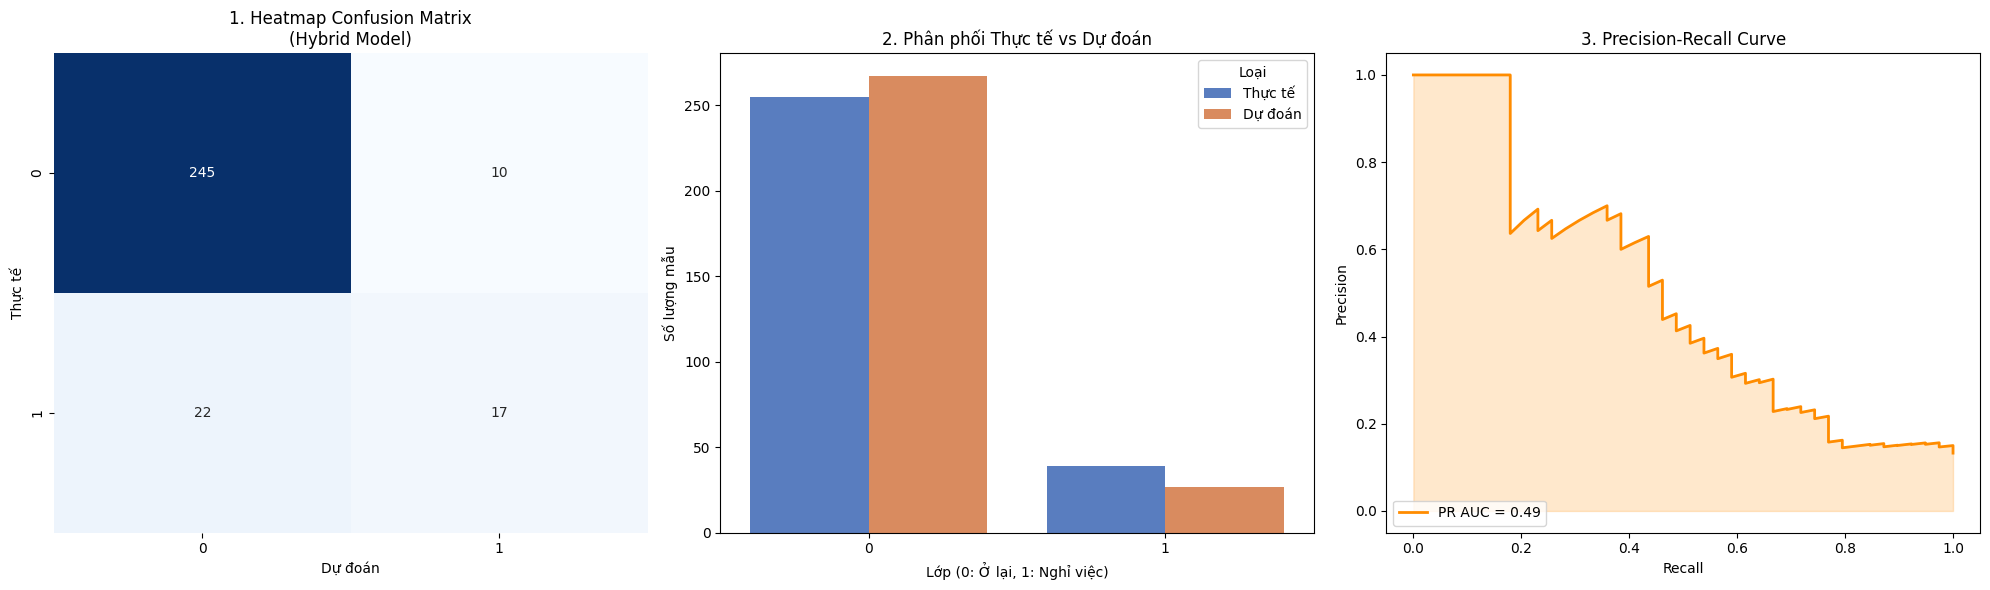

In [72]:
visualize_hybrid_results(my_gnb_end, my_bnb_end,
                        *train_test_split(X_copy_encode_2, y_copy_encode_2,test_size=0.2,random_state=42))

Nhận xét về độ phù hợp của mô hình với bài toán:
- Mô hình Naive Bayes nhìn chung phù hợp về mặt kỹ thuật, đặc biệt trong việc xử lý dữ liệu hỗn hợp (kết hợp giữa biến số và biến phân loại). Tuy nhiên, xét về hiệu quả ứng dụng trong bài toán dự đoán nhân viên nghỉ việc, mô hình chưa đáp ứng tốt yêu cầu kinh doanh, do khả năng phát hiện nhân viên có nguy cơ nghỉ việc (Recall) còn thấp.
- Việc áp dụng SMOTE giúp Recall của lớp “Yes” (nghỉ việc) tăng lên nhưng chỉ ở mức nhỏ, trong khi precision, F1-score và độ chính xác tổng thể đều giảm. Điều này cho thấy mô hình đánh đổi độ chính xác chung để cải thiện khả năng phát hiện lớp thiểu số, nhưng hiệu quả đạt được còn hạn chế, chưa đủ để sử dụng trong thực tế.

- Nguyên nhân:
    - Dữ liệu chưa đủ lớn, đặc biệt là số lượng mẫu thuộc lớp “Yes” (nghỉ việc) quá ít, khiến mô hình khó học được các đặc trưng đại diện cho nhóm này.

- Hướng cải thiện:
    - Để cải thiện hiệu quả, cần thu thập thêm dữ liệu thực, đặc biệt là các trường hợp nhân viên nghỉ việc, trước khi tiếp tục tối ưu mô hình hoặc áp dụng các kỹ thuật cân bằng dữ liệu.    